https://www.kaggle.com/c/ashrae-energy-prediction/

In [66]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8

* primary_use - назначение
* square_feet - площадь, кв.футы
* year_built - год постройки
* floor_count - число этажей

In [67]:
buildings = pd.read_csv("building_metadata.csv")
print (buildings.head())

   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN


* air_temperature - температура воздуха, С
* dew_temperature - точка росы (влажность), С
* cloud_coverage - облачность, %
* precip_depth_1_hr - количество осадков, мм/час
* sea_level_pressure - давление, мбар
* wind_direction - направление ветра, градусы
* wind_speed - скорость ветра, м/с

In [68]:
weather = pd.read_csv("weather_train.csv")
print (weather.head())

   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6  


Загрузила данные потребления энергии здания 0 (пока по нему попытаюсь построить предсказания)
* meter_reading - значение показателя (эквивалент тонн нефти)

   building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            0      0  2016-01-01 01:00:00            0.0
2            0      0  2016-01-01 02:00:00            0.0
3            0      0  2016-01-01 03:00:00            0.0
4            0      0  2016-01-01 04:00:00            0.0


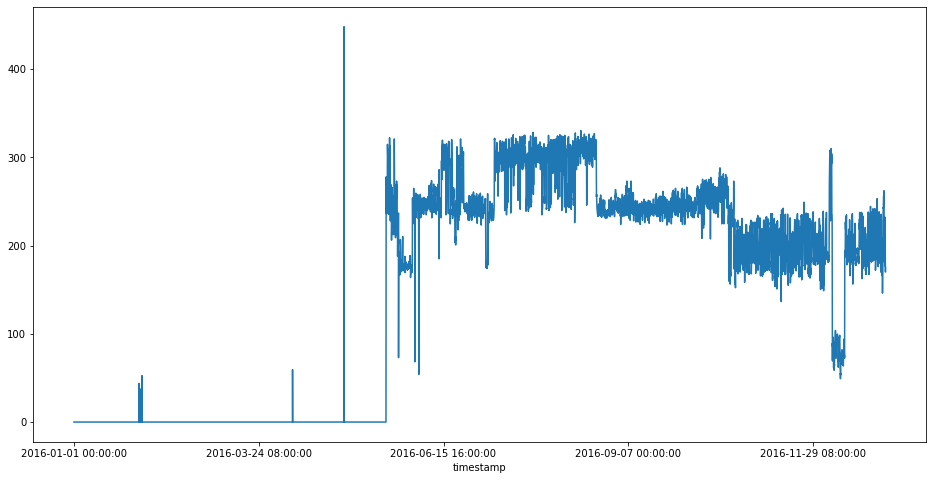

In [69]:
energy_0 = pd.read_csv("train.0.csv")
print (energy_0.head())
energy_0.set_index("timestamp")["meter_reading"].plot()
plt.show()

Cудя по графику, здание было запущено в эксплуатацию примерно в мае 2016г

Объединяем данные(потребление энергии и информацию о здании) по building_id

In [70]:
energy_0 = pd.merge(left=energy_0, right=buildings, how="left",
                   left_on="building_id", right_on="building_id")
print (energy_0.head())

   building_id  meter            timestamp  meter_reading  site_id  \
0            0      0  2016-01-01 00:00:00            0.0        0   
1            0      0  2016-01-01 01:00:00            0.0        0   
2            0      0  2016-01-01 02:00:00            0.0        0   
3            0      0  2016-01-01 03:00:00            0.0        0   
4            0      0  2016-01-01 04:00:00            0.0        0   

  primary_use  square_feet  year_built  floor_count  
0   Education         7432      2008.0          NaN  
1   Education         7432      2008.0          NaN  
2   Education         7432      2008.0          NaN  
3   Education         7432      2008.0          NaN  
4   Education         7432      2008.0          NaN  


Объединяем данные по потреблению энергии и погоде, потом сбрасываем индексы

In [71]:
energy_0.set_index(["timestamp", "site_id"], inplace=True)
weather.set_index(["timestamp", "site_id"], inplace=True)

In [72]:
energy_0 = pd.merge(left=energy_0, right=weather, how="left",
                   left_index=True, right_index=True)
energy_0.reset_index(inplace=True)
print (energy_0.head())

             timestamp  site_id  building_id  meter  meter_reading  \
0  2016-01-01 00:00:00        0            0      0            0.0   
1  2016-01-01 01:00:00        0            0      0            0.0   
2  2016-01-01 02:00:00        0            0      0            0.0   
3  2016-01-01 03:00:00        0            0      0            0.0   
4  2016-01-01 04:00:00        0            0      0            0.0   

  primary_use  square_feet  year_built  floor_count  air_temperature  \
0   Education         7432      2008.0          NaN             25.0   
1   Education         7432      2008.0          NaN             24.4   
2   Education         7432      2008.0          NaN             22.8   
3   Education         7432      2008.0          NaN             21.1   
4   Education         7432      2008.0          NaN             20.0   

   cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
0             6.0             20.0                NaN              10

Дальше по идее нужно заполнить пропуски, что-то погуглила на эту тему и решила заменить на такие значения:
* air_temperature: NaN заменила на 0
* cloud_coverage: NaN на 0
* dew_temperature: NaN на 0
* precip_depth_1_hr: NaN на 0, -1 на 0
* sea_level_pressure: NaN на среднее
* wind_direction: NaN на среднее 

In [73]:
energy_0["air_temperature"].fillna(0, inplace=True)
energy_0["cloud_coverage"].fillna(0, inplace=True)
energy_0["dew_temperature"].fillna(0, inplace=True)
energy_0["precip_depth_1_hr"] = energy_0["precip_depth_1_hr"].apply(lambda x:x if x>0 else 0)
energy_0_sea_level_pressure_mean = energy_0["sea_level_pressure"].mean()
energy_0["sea_level_pressure"] = energy_0["sea_level_pressure"].apply(lambda x:energy_0_sea_level_pressure_mean if x!=x else x)
energy_0_wind_direction_mean = energy_0["wind_direction"].mean()
energy_0["wind_direction"] = energy_0["wind_direction"].apply(lambda x:energy_0_wind_direction_mean if x!=x else x)
energy_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           8784 non-null   object 
 1   site_id             8784 non-null   int64  
 2   building_id         8784 non-null   int64  
 3   meter               8784 non-null   int64  
 4   meter_reading       8784 non-null   float64
 5   primary_use         8784 non-null   object 
 6   square_feet         8784 non-null   int64  
 7   year_built          8784 non-null   float64
 8   floor_count         0 non-null      float64
 9   air_temperature     8784 non-null   float64
 10  cloud_coverage      8784 non-null   float64
 11  dew_temperature     8784 non-null   float64
 12  precip_depth_1_hr   8784 non-null   float64
 13  sea_level_pressure  8784 non-null   float64
 14  wind_direction      8784 non-null   float64
 15  wind_speed          8784 non-null   float64
dtypes: flo

Дальше строим модель потребления энергии здания по часам. Погоду и характеристики здания тут пока не рассматривала

In [74]:
energy_0["timestamp"] = pd.to_datetime(energy_0["timestamp"])
energy_0["hour"] = energy_0["timestamp"].dt.hour
print (energy_0.head())

            timestamp  site_id  building_id  meter  meter_reading primary_use  \
0 2016-01-01 00:00:00        0            0      0            0.0   Education   
1 2016-01-01 01:00:00        0            0      0            0.0   Education   
2 2016-01-01 02:00:00        0            0      0            0.0   Education   
3 2016-01-01 03:00:00        0            0      0            0.0   Education   
4 2016-01-01 04:00:00        0            0      0            0.0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         7432      2008.0          NaN             24.4             0.0   
2         7432      2008.0          NaN             22.8             2.0   
3         7432      2008.0          NaN             21.1             2.0   
4         7432      2008.0          NaN             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressur

Среднее и медиана потребления энергии по часам:

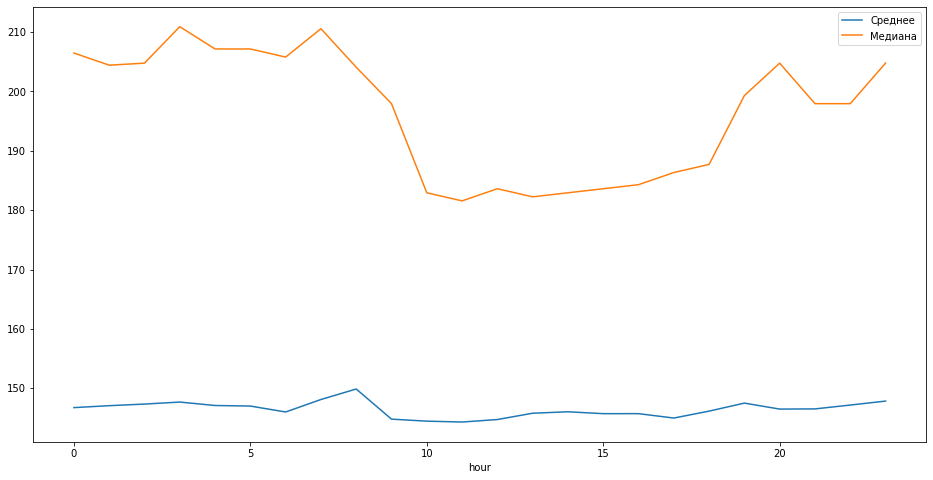

In [75]:
energy_0_hours = energy_0.groupby("hour")
energy_0_averages = pd.DataFrame(
    {"Среднее": energy_0_hours.mean()["meter_reading"],
     "Медиана": energy_0_hours.median()["meter_reading"]})
energy_0_averages.plot()
plt.show()

Значения очень сильно отличаются, т.к. очень много нулевых, это сильно влияет на среднее. Удаляем их, чтобы получить более точную картину

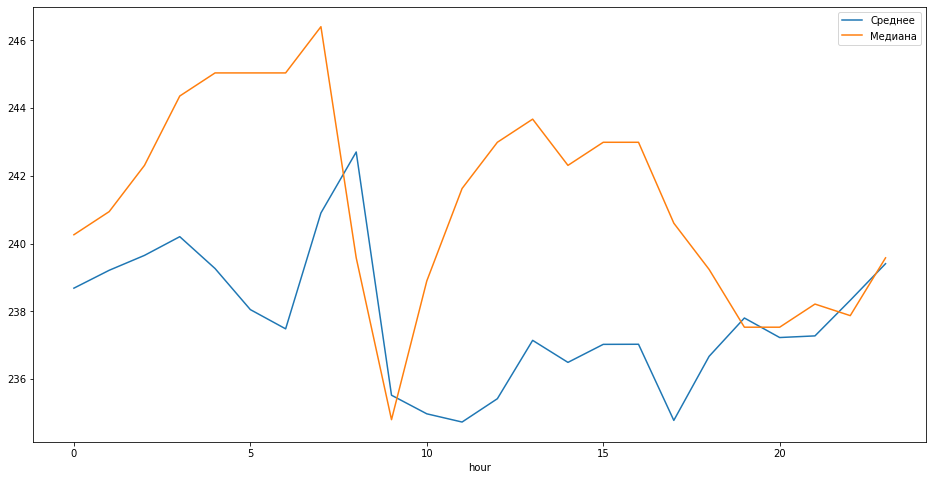

In [76]:
energy_0_hours_filtered = energy_0[energy_0["meter_reading"]>0].groupby("hour")
energy_0_averages_filtered = pd.DataFrame(
    {"Среднее": energy_0_hours_filtered.mean()["meter_reading"],
     "Медиана": energy_0_hours_filtered.median()["meter_reading"]})
energy_0_averages_filtered.plot()
plt.show()

Интерполируем данные по часам. Модель внутрисуточного потребление энергии по зданию:

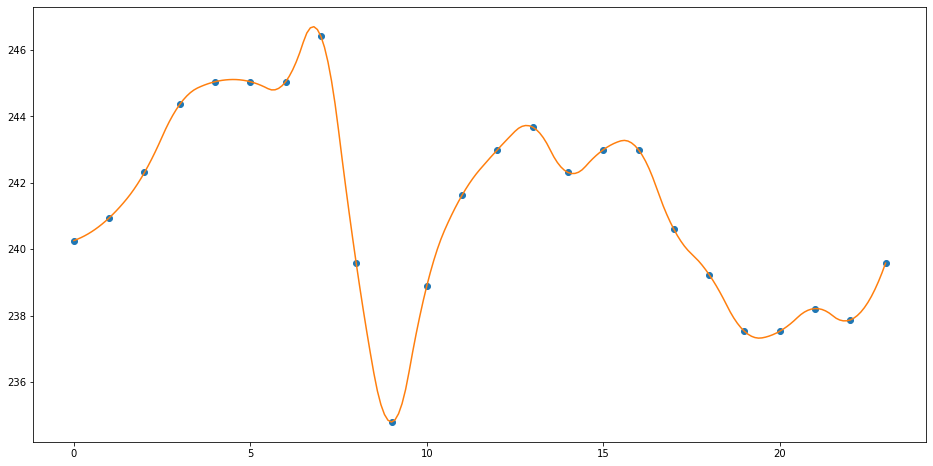

In [77]:
X = np.arange(0, 24)
y = interp1d(X, energy_0_hours_filtered.median()["meter_reading"], kind="quadratic")
Xn = np.arange(0, 23.01, 0.1)
yn = y(Xn)
plt.plot(X, energy_0_hours_filtered.median()["meter_reading"],
         'o', Xn, yn, '-')
plt.show()

Теперь строим модель энергопотребления здания по среднему значению, 
По условию ещё надо оценить эффективность модели через метрику:
\begin{equation}
RMSLE = {\sqrt{\sum_{i=1}^{n}{(log(p_i+1) - log(a_i+1))^2} \over n}}.
\end{equation}
* n - число наблюдений
* log - натуральный логарифм
* p_i - вычисленное значение метрики
* a_i - заданное значение метрики

Отсекла в данных пустые дни и выделила час из значения времени

In [92]:
energy_0 = pd.read_csv("train.0.csv")
energy_0 = energy_0[energy_0["meter_reading"] > 0]
energy_0["timestamp"] = pd.to_datetime(energy_0["timestamp"])
energy_0["hour"] = energy_0["timestamp"].dt.hour
print (energy_0.head())

      building_id  meter           timestamp  meter_reading  hour
704             0      0 2016-01-30 08:00:00        43.6839     8
725             0      0 2016-01-31 05:00:00        37.5408     5
737             0      0 2016-01-31 17:00:00        52.5571    17
2366            0      0 2016-04-08 14:00:00        59.3827    14
2923            0      0 2016-05-01 19:00:00       448.0000    19


Далее разделяем данные на обучение и проверку в соотношении 80/20

In [93]:
energy_0_train, energy_0_test = train_test_split(energy_0, test_size=0.2)
print (energy_0_train.head())

      building_id  meter           timestamp  meter_reading  hour
3966            0      0 2016-06-14 06:00:00        249.817     6
6184            0      0 2016-09-14 16:00:00        243.674    16
6055            0      0 2016-09-09 07:00:00        245.039     7
8433            0      0 2016-12-17 09:00:00        200.673     9
3588            0      0 2016-05-29 12:00:00        173.370    12


Среднее и медианa потребления энергии по часам:

In [94]:
energy_0_train_hours = energy_0_train.groupby("hour")
energy_0_train_averages = pd.DataFrame(
    {"Среднее": energy_0_train_hours.mean()["meter_reading"],
     "Медиана": energy_0_train_hours.median()["meter_reading"]})
print (energy_0_train_averages)

         Среднее   Медиана
hour                      
0     240.120678  240.9440
1     236.965865  240.6025
2     241.518773  242.3090
3     239.868944  244.3570
4     240.156761  244.6980
5     237.380931  245.0390
6     238.836755  245.7220
7     238.451301  246.4040
8     241.359265  238.8960
9     233.879428  235.4830
10    234.036997  238.2140
11    236.361955  241.6260
12    231.061337  241.9675
13    234.530882  243.3325
14    235.867751  242.3090
15    233.990439  241.6260
16    236.882936  242.6500
17    235.813597  242.3090
18    238.262014  240.2610
19    236.278396  237.5310
20    236.524498  237.5310
21    235.625830  237.1895
22    238.008048  238.5550
23    238.442253  239.5790


In [95]:
def calculate_model (X):
    meter_reading_log = np.log(X.meter_reading + 1)
    meter_reading_mean = np.log(energy_0_train_averages["Среднее"][X.hour] + 1)
    meter_reading_median = np.log(energy_0_train_averages["Медиана"][X.hour] + 1)
    X["meter_reading_mean_q"] = (meter_reading_log - meter_reading_mean)**2
    X["meter_reading_median_q"] = (meter_reading_log - meter_reading_median)**2
    return X

energy_0_test = energy_0_test.apply(calculate_model,
                                    axis=1, result_type="expand")
print (energy_0_test.head())

      building_id  meter           timestamp  meter_reading  hour  \
3570            0      0 2016-05-28 18:00:00        176.783    18   
4365            0      0 2016-06-30 21:00:00        226.610    21   
6790            0      0 2016-10-09 22:00:00        269.611    22   
7878            0      0 2016-11-24 06:00:00        171.323     6   
6397            0      0 2016-09-23 13:00:00        251.182    13   

      meter_reading_mean_q  meter_reading_median_q  
3570              0.088206                0.093218  
4365              0.001509                0.002064  
6790              0.015422                0.014859  
7878              0.109288                0.128803  
6397              0.004666                0.001000  


In [96]:
energy_0_test_median_rmsle = np.sqrt(energy_0_test["meter_reading_median_q"].sum() / len(energy_0_test))
energy_0_test_mean_rmsle = np.sqrt(energy_0_test["meter_reading_mean_q"].sum() / len(energy_0_test))
print ("Качество median:", energy_0_test_median_rmsle)
print ("Качество mean:", energy_0_test_mean_rmsle)

Качество median: 0.2526086601243382
Качество mean: 0.25136470199737176


Далее строим модель потребления энергии здания, используя температуру воздуха (air_temperature) и влажность (dew_temperature).
Ещё там потом по условию нужно тоже рассчитать качество построенных моделей по проверочным данным

In [97]:
buildings = pd.read_csv("building_metadata.csv")
weather = pd.read_csv("weather_train.csv")
energy_0 = pd.read_csv("train.0.csv")

energy_0 = pd.merge(left=energy_0, right=buildings, how="left",
                   left_on="building_id", right_on="building_id")
energy_0.set_index(["timestamp", "site_id"], inplace=True)
weather.set_index(["timestamp", "site_id"], inplace=True)
energy_0 = pd.merge(left=energy_0, right=weather, how="left",
                   left_index=True, right_index=True)
energy_0.reset_index(inplace=True)
energy_0 = energy_0[energy_0["meter_reading"] > 0]
energy_0["timestamp"] = pd.to_datetime(energy_0["timestamp"])
energy_0["hour"] = energy_0["timestamp"].dt.hour
print (energy_0.head())

               timestamp  site_id  building_id  meter  meter_reading  \
704  2016-01-30 08:00:00        0            0      0        43.6839   
725  2016-01-31 05:00:00        0            0      0        37.5408   
737  2016-01-31 17:00:00        0            0      0        52.5571   
2366 2016-04-08 14:00:00        0            0      0        59.3827   
2923 2016-05-01 19:00:00        0            0      0       448.0000   

     primary_use  square_feet  year_built  floor_count  air_temperature  \
704    Education         7432      2008.0          NaN              8.3   
725    Education         7432      2008.0          NaN             12.8   
737    Education         7432      2008.0          NaN             20.6   
2366   Education         7432      2008.0          NaN             21.7   
2923   Education         7432      2008.0          NaN             31.1   

      cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
704              NaN              6.

In [98]:
energy_0["timestamp"] = pd.to_datetime(energy_0["timestamp"])
energy_0["hour"] = energy_0["timestamp"].dt.hour

In [99]:
energy_0_train, energy_0_test = train_test_split(energy_0, test_size=0.2)
print (energy_0_train.head())

               timestamp  site_id  building_id  meter  meter_reading  \
6643 2016-10-03 19:00:00        0            0      0       231.3880   
3968 2016-06-14 08:00:00        0            0      0       238.2140   
8334 2016-12-13 06:00:00        0            0      0        81.9072   
3386 2016-05-21 02:00:00        0            0      0       247.0870   
3453 2016-05-23 21:00:00        0            0      0       229.3400   

     primary_use  square_feet  year_built  floor_count  air_temperature  \
6643   Education         7432      2008.0          NaN             30.6   
3968   Education         7432      2008.0          NaN             25.0   
8334   Education         7432      2008.0          NaN             18.3   
3386   Education         7432      2008.0          NaN             26.1   
3453   Education         7432      2008.0          NaN             30.0   

      cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
6643             NaN             21.

Затем строим модель линейной регрессии
* meter_reading = A * air_temperature + B * dew_temperature + C

Дополнительно вычисляю среднее по часам, чтобы сравнить линейную регрессию с более простой моделью

In [100]:
energy_0_train_averages = energy_0_train.groupby("hour").mean()["meter_reading"]

energy_0_train_models = pd.DataFrame(energy_0_train, columns=["meter_reading", "air_temperature", "dew_temperature"])
y = energy_0_train_models["meter_reading"]
X = energy_0_train_models.drop(labels=["meter_reading"], axis=1)
model_lr = LinearRegression().fit(X, y)
print (model_lr.coef_, model_lr.intercept_)
model_lasso = Lasso(alpha=0.01).fit(X, y)
print (model_lasso.coef_, model_lasso.intercept_)
model_br = BayesianRidge().fit(X, y)
print (model_br.coef_, model_br.intercept_)

[2.25032519 3.97087866] 104.40523080796521
[2.25036279 3.97045457] 104.41254712571094
[2.2512287  3.96470464] 104.50287283770803


In [101]:
def calculate_model (X):
    meter_reading_log = np.log(X.meter_reading + 1)
    meter_reading_mean = np.log(energy_0_train_averages[X.hour] + 1)
    meter_reading_lr = np.log(1 + X.air_temperature * model_lr.coef_[0] + 
                                  X.dew_temperature * model_lr.coef_[1] +
                                  model_lr.intercept_)
    meter_reading_lasso = np.log(1 + X.air_temperature * model_lasso.coef_[0] + 
                                  X.dew_temperature * model_lasso.coef_[1] +
                                  model_lasso.intercept_)
    meter_reading_br = np.log(1 + X.air_temperature * model_br.coef_[0] + 
                                  X.dew_temperature * model_br.coef_[1] +
                                  model_br.intercept_)
    X["meter_reading_lr_q"] = (meter_reading_log - meter_reading_lr)**2
    X["meter_reading_lasso_q"] = (meter_reading_log - meter_reading_lasso)**2
    X["meter_reading_br_q"] = (meter_reading_log - meter_reading_br)**2
    X["meter_reading_mean_q"] = (meter_reading_log - meter_reading_mean)**2
    return X

energy_0_test = energy_0_test.apply(calculate_model,
                                    axis=1, result_type="expand")
energy_0_test_lr_rmsle = np.sqrt(energy_0_test["meter_reading_lr_q"].sum() / len(energy_0_test))
energy_0_test_lasso_rmsle = np.sqrt(energy_0_test["meter_reading_lasso_q"].sum() / len(energy_0_test))
energy_0_test_br_rmsle = np.sqrt(energy_0_test["meter_reading_br_q"].sum() / len(energy_0_test))
energy_0_test_mean_rmsle = np.sqrt(energy_0_test["meter_reading_mean_q"].sum() / len(energy_0_test))
print ("Качество mean:", energy_0_test_mean_rmsle)
print ("Качество Linear Regression:", energy_0_test_lr_rmsle)
print ("Качество Lasso:", energy_0_test_lasso_rmsle)
print ("Качество Bayesian Ridge:", energy_0_test_br_rmsle)

Качество mean: 0.25476581075979116
Качество Linear Regression: 0.21323389367692352
Качество Lasso: 0.2132340299639148
Качество Bayesian Ridge: 0.21323559193090322


коэфициенты Linear Regression, Lasso и Bayesian Ridge почти не отличаются друг от друга, качество тоже не сильно меняется, следовательно, использование каких-то других методов помимо линейной регрессии не даст нам никакого особого выйгрыша в данной задачe